In [1]:
import numpy as np
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt

%matplotlib inlines

### Data preparation

In [2]:
def txt_to_matrix(filename, line_skip = 5):
    f = open (filename, 'r')
    
    # Lineskip, cleaning, conversion
    data = f.readlines()[line_skip:]
    
    data = np.asarray(
        [l.replace("\n", "").split() for l in data]
    ).astype(np.float32)
    
    data[data > 100] = 0
    
    return data

In [3]:
def get_dep_time_step(root):

    dep = txt_to_matrix(root)
    
    # timestep: matrice 801 rows x 4 misurazioni x 1256 colonne (valori)
    return np.array(dep)

In [4]:
rootdir = '../input/'
timesteps = []

paths = [p for p in sorted(os.listdir(rootdir))]

# Read all dirs and process them
for path in tqdm.tqdm(paths):    
    # Processing
    path = rootdir + path
    
    if path.endswith("DEP"):
        timesteps.append(get_dep_time_step(path))
        
timesteps = np.asarray(timesteps)

100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


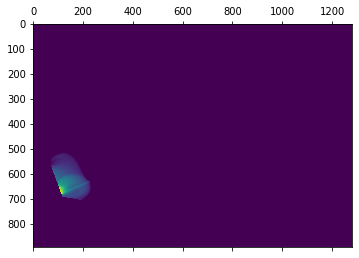

In [5]:
plt.matshow(timesteps[3, :, :])

Text(0, 0.5, 'Depth')

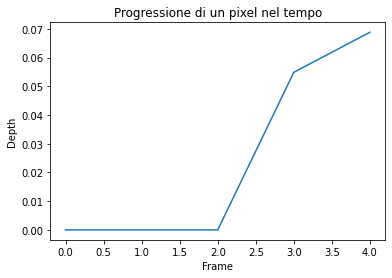

In [6]:
plt.plot(timesteps[:, 620, 180])
plt.title("Progressione di un pixel nel tempo")
plt.xlabel("Frame")
plt.ylabel("Depth")

### Building the net

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D
from tensorflow.keras.optimizers import Adam

### Building the model

In [8]:
frame_number, row_number, column_number = np.shape(timesteps)
input_shape = (1, row_number, column_number, 1)

model = Sequential([
    Conv2D(
        batch_input_shape = input_shape,
        filters = 1,
        kernel_size = [2,2],
        activation = "relu",
        padding = "same"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 896, 1280, 1)         5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss = "mean_squared_error", metrics = ["accuracy"])

# Feed to the CNN a matrix and verify with it's successor
for index in range(frame_number - 1):
    input = timesteps[index].reshape(1, row_number, column_number, 1)
    output = timesteps[index + 1].reshape(1, row_number, column_number, 1)

    model.fit(x = input, y = output, epochs = 1, verbose = 2)

predictions = []
prediction = timesteps[frame_number - 1].reshape(1, row_number, column_number, 1)

selected_image = frame_number - 1
prediction = model.predict(x = timesteps[selected_image].reshape(1, row_number, column_number, 1), verbose = 1)

prediction = np.array(prediction).reshape(row_number, column_number)

1/1 - 0s - loss: 7.2157e-06 - accuracy: 0.9927
1/1 - 0s - loss: 1.4110e-05 - accuracy: 0.9880
1/1 - 0s - loss: 1.7413e-05 - accuracy: 0.9818
1/1 - 0s - loss: 1.9192e-05 - accuracy: 0.9750
1/1 [==============================] - 0s 2ms/step


### Input data images

Input images:


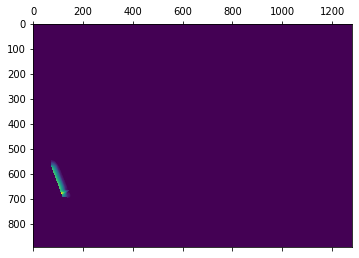

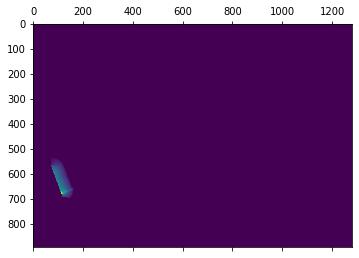

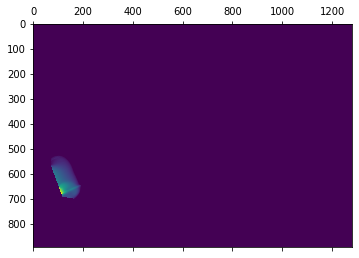

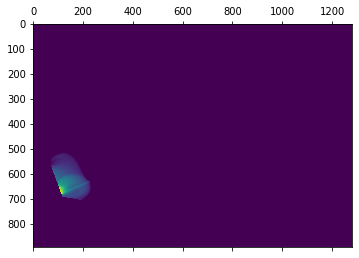

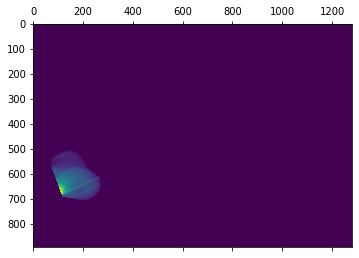

In [20]:
print("Input images:")
for i in range(frame_number):
    plt.matshow(timesteps[i])

### Prediction images

Prediction image:
(896, 1280)


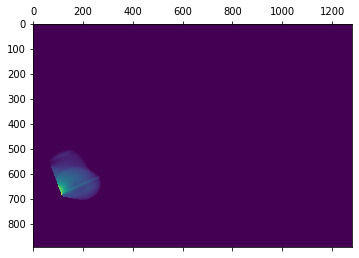

In [19]:
print("Prediction image:")
print(prediction.shape)
plt.matshow(prediction)

### Accuracy function

In [33]:
dist = (prediction - timesteps[frame_number - 1])**2
dist = np.sum(dist, axis=1)
dist = np.sqrt(dist)

1 - dist.flatten().mean()

0.9590659253299236